# Scope

Notebook that takes the preprocessed data from the preprocessing notebook and trains a CatBoost model.

The final scope of this notebook is to see what features have the most influence on predicting the price of a listing.

# Import Libraries

In [1]:
import json

from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import catboost as cb
import shap

from sklearn.metrics import r2_score, mean_squared_error

# Load Data

In [2]:
features_dir = Path("data") / "features"

X_train = pd.read_csv(features_dir / "X_train.csv")
X_test = pd.read_csv(features_dir / "X_test.csv")
y_train = pd.read_csv(features_dir / "y_train.csv")
y_test = pd.read_csv(features_dir / "y_test.csv")

with open(features_dir / "meta.json", "r") as f:
    meta = json.load(f)

categorical_features = meta["categorical_features"]

In [3]:
X_train.head()

,host_id,host_since,host_response_rate,host_acceptance_rate,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bedrooms,...,host_verifications_email,host_verifications_government_id,host_verifications_jumio,host_verifications_phone,host_verifications_reviews,instant_bookable,is_bathroom_private,neighbourhood_cleansed,property_type,room_type
0,53335715,0.539695,0.0,0.40,0,0,52.36261,4.85446,2,1.0,...,0,0,0,0,0,0,0,0,0,0
1,9282300,0.373401,0.2,0.86,9,9,52.36430,4.88867,2,1.0,...,0,0,0,0,0,0,0,1,1,0
2,16582432,0.423147,1.0,0.71,1,1,52.35396,4.87842,5,3.0,...,0,1,0,0,1,0,0,2,2,0
3,1901477,0.256650,1.0,0.90,1,1,52.37420,4.90401,2,1.0,...,0,1,0,0,1,1,0,1,3,0
4,31540174,0.486904,1.0,1.00,2,2,52.35646,4.88986,4,3.0,...,0,1,0,0,1,1,0,3,1,0


In [4]:
X_test.head()

,host_id,host_since,host_response_rate,host_acceptance_rate,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bedrooms,...,host_verifications_email,host_verifications_government_id,host_verifications_jumio,host_verifications_phone,host_verifications_reviews,instant_bookable,is_bathroom_private,neighbourhood_cleansed,property_type,room_type
0,7012495,0.351269,1.00,0.71,0,0,52.36084,4.89542,4,3.0,...,0,1,0,0,1,0,0,1,1,0
1,19965139,0.436345,1.00,0.80,1,1,52.35984,4.85391,4,1.0,...,0,1,0,0,1,0,0,0,1,0
2,72558816,0.566904,0.90,0.43,2,2,52.36840,4.86567,2,1.0,...,0,0,0,0,1,0,0,0,21,0
3,56997633,0.545381,1.00,1.00,3,3,52.38951,4.87912,2,1.0,...,1,0,0,0,1,1,1,34,8,1
4,85420364,0.580508,0.97,1.00,4,4,52.37106,4.89581,2,1.0,...,0,0,0,0,1,1,1,5,8,1


In [5]:
categorical_features

['host_response_time',
 'host_is_superhost',
 'host_neighbourhood',
 'host_has_profile_pic',
 'host_identity_verified',
 'neighbourhood_cleansed',
 'property_type',
 'room_type',
 'has_availability',
 'instant_bookable',
 'city',
 'has_license',
 'is_bathroom_private',
 'host_verifications_phone',
 'host_verifications_email',
 'host_verifications_jumio',
 'host_verifications_reviews',
 'host_verifications_government_id',
 'amenities_Wifi',
 'amenities_Essentials',
 'amenities_Smoke alarm',
 'amenities_Heating',
 'amenities_Hangers',
 'amenities_Hair dryer',
 'amenities_Hot water',
 'amenities_Kitchen',
 'amenities_Long term stays allowed',
 'amenities_Iron',
 'host_id']

In [6]:
y_train

,price
0,100.0
1,175.0
2,345.0
3,320.0
4,300.0
...,...
5714,94.0
5715,150.0
5716,239.0
5717,78.0


In [7]:
y_test.head()

,price
0,350.0
1,200.0
2,166.0
3,95.0
4,106.0


# Train

In [8]:
train_dataset = cb.Pool(X_train, y_train, cat_features=categorical_features)
test_dataset = cb.Pool(X_test, y_test, cat_features=categorical_features)

model = cb.CatBoostRegressor(loss_function="RMSE")

grid = {'iterations': [100, 150, 200],
        'learning_rate': [0.03, 0.1],
        'depth': [2, 4, 6, 8],
        'l2_leaf_reg': [0.2, 0.5, 1, 3]}
model.grid_search(grid, train_dataset)

0:	learn: 193.8168633	test: 186.3978156	best: 186.3978156 (0)	total: 47.2ms	remaining: 4.67s
1:	learn: 189.5374527	test: 182.0001905	best: 182.0001905 (1)	total: 48.3ms	remaining: 2.37s
2:	learn: 185.4829200	test: 177.8687246	best: 177.8687246 (2)	total: 49.5ms	remaining: 1.6s
3:	learn: 181.5852389	test: 173.8787204	best: 173.8787204 (3)	total: 51.3ms	remaining: 1.23s
4:	learn: 177.7819694	test: 170.0593526	best: 170.0593526 (4)	total: 53.2ms	remaining: 1.01s
5:	learn: 174.1659157	test: 166.3843295	best: 166.3843295 (5)	total: 54.4ms	remaining: 852ms
6:	learn: 170.7389923	test: 162.8962123	best: 162.8962123 (6)	total: 55.1ms	remaining: 733ms
7:	learn: 167.5594253	test: 159.6629505	best: 159.6629505 (7)	total: 55.6ms	remaining: 640ms
8:	learn: 164.5114864	test: 156.5677248	best: 156.5677248 (8)	total: 56.8ms	remaining: 574ms
9:	learn: 161.6157937	test: 153.6232740	best: 153.6232740 (9)	total: 57.3ms	remaining: 516ms
10:	learn: 158.6859760	test: 150.6103148	best: 150.6103148 (10)	total: 

{'params': {'depth': 8,
  'iterations': 150,
  'learning_rate': 0.1,
  'l2_leaf_reg': 0.2},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               4

# Test

In [9]:
y_test_pred = model.predict(X_test)

print(f"R2 Score: {r2_score(y_test, y_test_pred):.4f}")
print(f"RMSE Score: {mean_squared_error(y_test, y_test_pred, squared=False):.4f}")

R2 Score: 0.5403
RMSE Score: 75.2474


# Plot Feature Importance

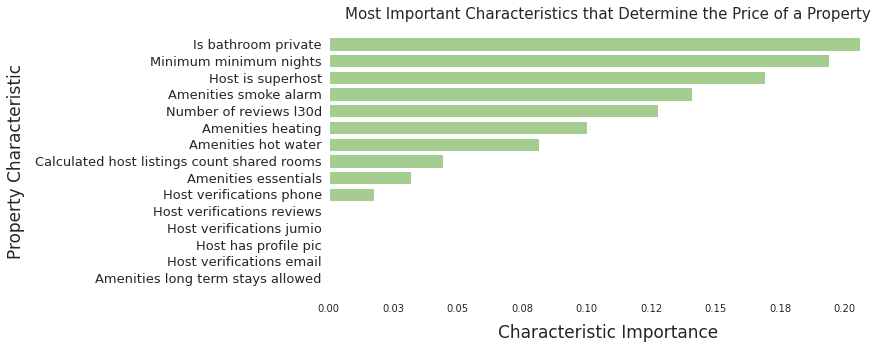

In [10]:
import seaborn as sns

from matplotlib.ticker import FormatStrFormatter

plt.rcParams["axes.prop_cycle"] = plt.cycler("color", sns.color_palette("crest", as_cmap=True).colors)

sorted_feature_importance = model.feature_importances_.argsort()[:15]
display_features = X_train.columns[sorted_feature_importance]
display_features = [" ".join(f.capitalize().split("_")) for f in display_features]
_, ax = plt.subplots(1, 1, figsize=(10, 5))
plt.barh(
    display_features,
    model.feature_importances_[sorted_feature_importance],
)
ax.set_facecolor("white")
ax.set_xlabel("Characteristic Importance", fontsize=17)
ax.set_ylabel("Property Characteristic", fontsize=17)
ax.tick_params(axis='y', which='major', labelsize=13)
ax.xaxis.labelpad = 10
ax.yaxis.labelpad = 10

for txt in ax.texts:
    txt.set_visible(False)

ax.xaxis.set_major_formatter(FormatStrFormatter('%1.2f'))

plt.title("Most Important Characteristics that Determine the Price of a Property", fontsize=15)
plt.savefig(Path("images") / "catboost.png", bbox_inches = "tight")

In [11]:
X_test.columns[sorted_feature_importance]

Index(['amenities_Long term stays allowed', 'host_verifications_email',
       'host_has_profile_pic', 'host_verifications_jumio',
       'host_verifications_reviews', 'host_verifications_phone',
       'amenities_Essentials', 'calculated_host_listings_count_shared_rooms',
       'amenities_Hot water', 'amenities_Heating', 'number_of_reviews_l30d',
       'amenities_Smoke alarm', 'host_is_superhost', 'minimum_minimum_nights',
       'is_bathroom_private'],
      dtype='object')

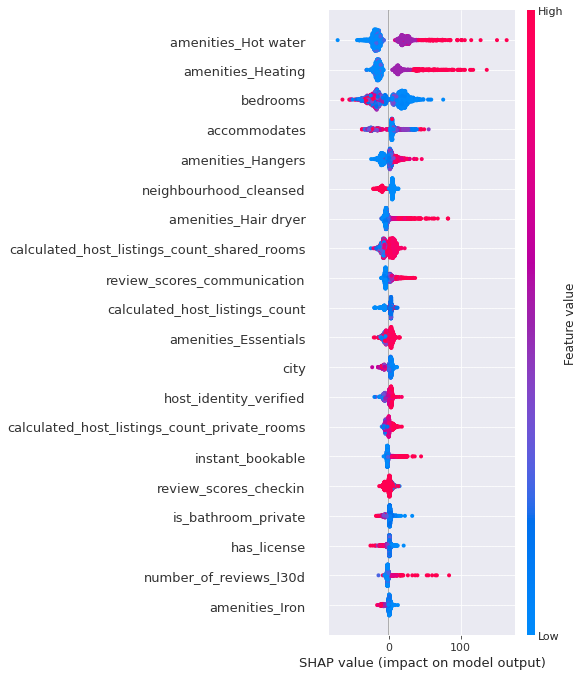

In [12]:
explainer = shap.TreeExplainer(model)

features_to_look_at = model.feature_importances_.argsort()
features_to_look_at = list(X_test.columns[features_to_look_at])
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=features_to_look_at)